[루브릭]

1. 프로젝트 1, 2를 정상적인 흐름대로 진행하였는가?	
    - 데이터 라벨링 방법 4가지 및 각종 지표를 적용한 데이터셋을 활용하여 특성선택을 시도하였다.
    
<br></br>

2. 프로젝트 3에서 다양한 방법을 사용하여 기존의 결과와 비교 분석 시도하였는가?	
    - PKFold의 split 개수, 데이터 비율, 데이터 개수 등의 파라미터 변경 및 모델 변경을 시도하고 기존의 결과와 비교하였다.

<br></br>
    
3. 다양한 방법을 사용하여 성능향상을 시도하였는가?
    - classification report에서 accuracy, precision, recall의 성능을 5% 이상 향상시켰다.
    
<br></br>


# 1. 프로젝트 : Data Labeling

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

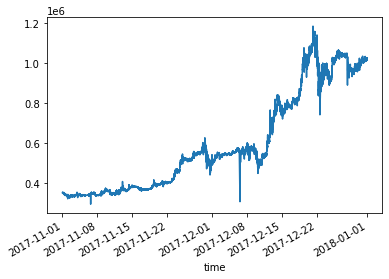

In [2]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

## ① Price Change Direction 적용하기

In [3]:
# Q. 코드를 작성해주세요

# window 지정
window = 10

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1) 
# modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index) 
# 데이터 활용을 위해 pd.Series를 사용합니다.

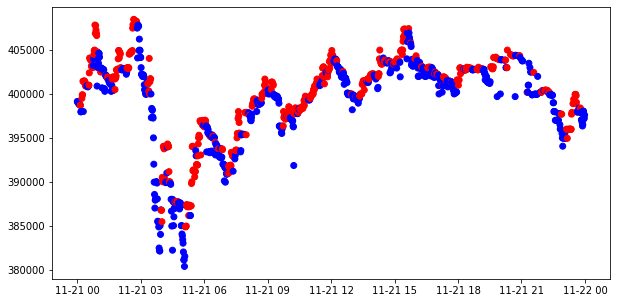

In [4]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']
# loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']
# loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')
# np.where 사용

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

## ② Using Moving Average 적용하기

In [5]:
# Q. 코드를 작성해주세요

# momentum_signal 
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1) # modify_data['close'].rolling(window).mean() 활용

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)
# pd.Series로 변환

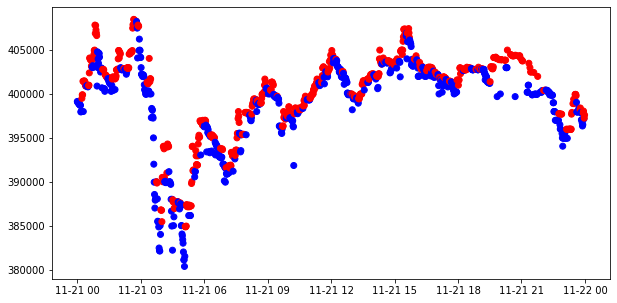

In [6]:
# Q. 코드를 작성해주세요

# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

## ③ Local Min-Max 적용하기

In [13]:
# Q. 코드를 작성해주세요

# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0] # ①
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val # ②
            maxes.append(max_value)  # ③
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True # ④
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False # ⑤
            n_cnt_max +=1 # ⑥
            if n_cnt_max >= wait:
                min_value = max_value # ⑦
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}),\
pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})# ⑧

In [14]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

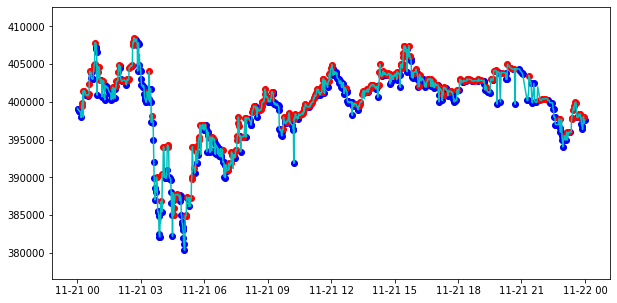

In [15]:
# Q. 코드를 작성해주세요

# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins.min_time, mins.local_min, c='blue')

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes.max_time, maxes.local_max, c='red')

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

## ④ Trend Scanning 적용하기

In [17]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [18]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [19]:
# Q. 코드를 작성해주세요

# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:21<00:00, 41.63it/s]


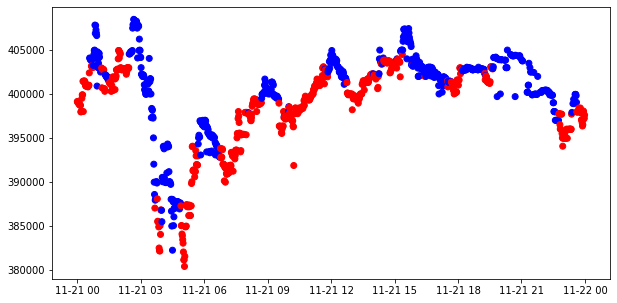

In [20]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

# 2. 프로젝트: Feature Engineering

## ① 환경구성 및 데이터 불러오기

In [21]:
!pip install ta==0.9.0
!pip install shap

In [22]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [23]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

## ② Technical Index 적용하기

In [24]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [25]:
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,volatility_atr,volatility_ui,trend_macd_diff,trend_adx,trend_trix,trend_mass_index,trend_dpo,trend_aroon_ind,momentum_rsi,momentum_wr
time,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,1416.425464,0.361107,652.357742,20.661135,-0.018034,23.066052,-225.0,-35.0,52.934202,-0.0
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,1574.782918,0.349329,482.768654,21.007559,-0.016660,23.029259,-2100.0,-35.0,44.041843,-62.5
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,1517.304626,0.342452,280.010175,21.537826,-0.015683,22.971985,-1925.0,-35.0,41.083991,-87.5


In [26]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [27]:
df_

,open,high,low,close,volume,volume_cmf,volume_fi,volume_mfi,volume_sma_em,volume_vpt,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1028000,1028000,1026500,1028000,41.835689,NaN,NaN,NaN,NaN,-0.796083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:01:00,1028000,1029000,1026000,1028500,22.307810,NaN,NaN,NaN,NaN,-0.788285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:02:00,1028000,1029000,1028000,1028000,59.276102,NaN,NaN,NaN,NaN,-0.017967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,1028000,1028000,1014000,1014000,114.203740,NaN,NaN,NaN,NaN,-1.584121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:04:00,1020000,1027000,1014500,1025000,62.695404,NaN,NaN,NaN,NaN,-0.875176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 16:35:00,1052500,1052500,1052500,1052500,6.084122,-0.232633,-2275.848327,71.279251,-3.186964e+12,0.007381,...,52.934202,-0.0,-0.817192,0.002381,-0.265538,0.003815,0.703781,0.000000,1811.600550,15.025354
2018-01-01 16:36:00,1052500,1052500,1049500,1050000,9.205537,-0.165805,-4868.097577,67.762226,-3.097651e+12,-0.021866,...,44.041843,-62.5,0.394890,0.000000,0.274989,0.001431,-0.625893,-0.002375,1787.568824,9.944774
2018-01-01 16:37:00,1050000,1050000,1049000,1049000,3.472849,-0.161093,-4693.691500,74.267351,-5.977131e+12,-0.025173,...,41.083991,-87.5,-0.279019,-0.001903,-0.609186,0.000477,-0.849066,-0.003325,1763.291071,9.932495


In [28]:
# Q. 코드를 작성해주세요

df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1]
# iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [29]:
# Q. 코드를 작성해주세요

# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight='balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

## ③ Feature Selection methods 적용하기

### MDI, Mean Decrease Impurity

In [30]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.043416,0.002031
volume_fi,0.043321,0.002311
volume_mfi,0.046035,0.002292
volume_sma_em,0.038376,0.002049
volume_vpt,0.027527,0.001662
volatility_atr,0.076724,0.002787
volatility_ui,0.051227,0.002823
trend_macd_diff,0.081729,0.003941
trend_adx,0.050204,0.002000
trend_trix,0.072012,0.003233


### MDA, Mean Decrease Accuracy

In [31]:
# MDA, Mean Decrease Accuracy
# svc_rbf = SVC(kernel='rbf', probability=True)
# Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.

from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

cv = KFold(n_splits=3) # n_splits을 변경해봅시다.
feat_imp_mda = imp.mean_decrease_accuracy(log_reg, X_sc, y, cv_gen=cv)

In [32]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

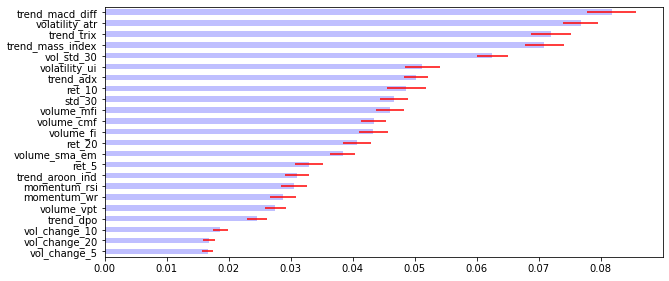

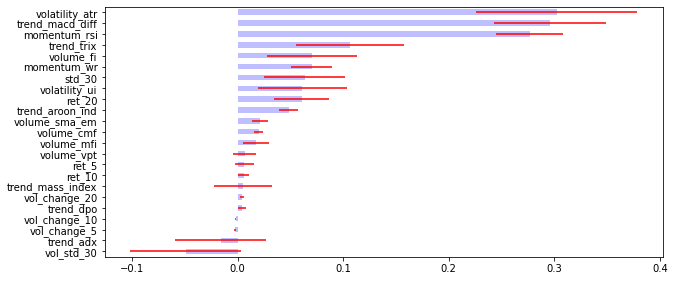

In [33]:
# Q. 코드를 작성해주세요

# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

### RFE CV, Recursive Feature Elimination

In [35]:
# Q. 코드를 작성해주세요

# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv) # RFECV
rfe_fitted = rfe_cv.fit(X_sc, y) # fit

In [37]:
# 선택된 피쳐 확인하기

rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T\
.rename(columns={0: 'Optimal_Features', 1: 'Ranking'})
rfe_df

,Optimal_Features,Ranking
volume_cmf,False,7
volume_fi,True,1
volume_mfi,False,9
volume_sma_em,False,2
volume_vpt,False,3
volatility_atr,True,1
volatility_ui,False,6
trend_macd_diff,True,1
trend_adx,False,14
trend_trix,False,5


### SFS, Sequential Feature Selection

In [40]:
# SFS, Sequential Feature Selection

n = 2
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [41]:
# 선택된 피쳐 확인하기

sfs_rank = sfs_fitted.get_support()
sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns={'Optimal_Features'})

sfs_df[sfs_df['Optimal_Features']==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

### SHAP, Shapley Additive explanations

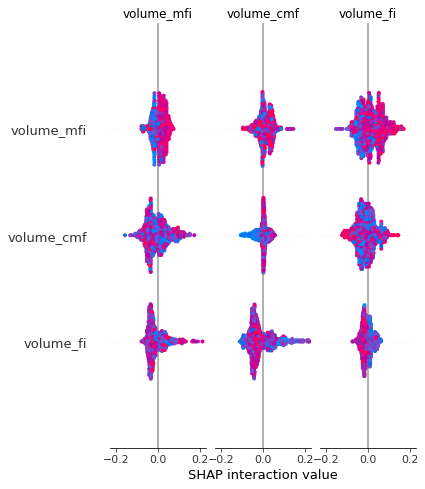

In [42]:
# Q. 코드를 작성해주세요

# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

In [45]:
output_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_tmp_data.to_pickle(output_file_name)

# 3. 프로젝트 : Model Traning

## ① 환경구성 및 데이터 불러오기

In [43]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [65]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)


# Trial 1)
# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
# train_x = train_x[:1000]
# train_y = train_y[:1000]

# Trial 2) 1500개로 감소
# train_x = train_x[:1500] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
# train_y = train_y[:1500]

# Trial 3) 다시 1000개로 감소
train_x = train_x[:1000] 
train_y = train_y[:1000]

# Trial 4) 1000개로 유지
train_x = train_x[:1000] 
train_y = train_y[:1000]

## ② Purged K-fold for Cross-Validation적용하기

In [87]:
# Q. 코드를 작성해주세요

# Trial 1)
# n_cv = 4

# Trial 2)
# n_cv = 6
# 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
# 위에서 1000개의 데이터 대신 1500개로 샘플 데이터를 늘렸습니다. 
# 샘플 사이즈가 늘어난 만큼 각 폴드의 validation set의 사이즈가 일정하게 유지되려면 비슷한 비율로 늘려줘야 한다고 생각했습니다. 

# Trial 3)
# n_cv = 4

# Trial 4)
n_cv = 4

t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

## ③ Model 적용하기

In [95]:
# Trial 1)
# bc_params = {'n_estimators': [5, 10, 20], # top 30 중 10: 11, 20: 10, 5: 9
#              'max_features': [0.5, 0.7], # top 30 중 0.7: 21, 0.5: 9 
#              'base_estimator__max_depth': [3,5,10,20], # top 30 중 3: 10, 5: 9, 10: 6, 20: 5
#              'base_estimator__max_features': [None, 'auto'], # top 30 중 None: 28, 'auto': 2
#              'base_estimator__min_samples_leaf': [3, 5, 10], # top 30 중 10: 18, 5: 11, 3: 1
#              'bootstrap_features': [False, True] # top 30 중 False: 18, True: 12
#             }

# Trial 2)
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
# bc_params = {'n_estimators': [10, 15, 20], # top 30 중 10: 11, 15: 11, 20: 8
#              'max_features': [0.6, 0.7], # top 30 중 0.6: 17, 0.7: 13
#              'base_estimator__max_depth': [3, 5, 7, 10], # top 30 중 3: 11, 10: 8, 5: 6, 7: 5
#              'base_estimator__max_features': [None], 
#              'base_estimator__min_samples_leaf': [8, 9, 10], # top 30 중 10: 15, 9: 9, 8: 6
#              'bootstrap_features': [False, True] # top 30 중 True: 22, False: 8
#             }

# Trial 3)
# bc_params = {'n_estimators': [10, 13, 25], # top 30 중 25: 12, 10: 10, 13: 8 
#              'max_features': [0.6, 0.65], # top 30 중 
#              'base_estimator__max_depth': [3, 5, 10], # top 30 중 
#              'base_estimator__max_features': [None], # top 30 중 
#              'base_estimator__min_samples_leaf': [9, 10], # top 30 중 
#              'bootstrap_features': [True] 
#             }

# Trial 4)
bc_params = {'n_estimators': [10, 13, 15], 
             'max_features': [0.6, 0.65], 
             'base_estimator__max_depth': [3, 4, 5], 
             'base_estimator__max_features': [None], 
             'base_estimator__min_samples_leaf': [9, 10], 
             'bootstrap_features': [True] 
            }

25    12
10    10
13     8
Name: param_n_estimators, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


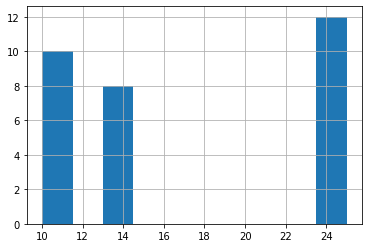

In [93]:
print(best_cv_results['param_n_estimators'].value_counts())
print(best_cv_results['param_n_estimators'].hist())

In [96]:
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

In [97]:
# Q. 코드를 작성해주세요

# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

In [98]:
# Q. 코드를 작성해주세요

# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [99]:
# fit
gs_rfc.fit(train_x, train_y)

# Trial 1)
# Fitting 4 folds for each of 288 candidates, totalling 1152 fits

# Trial 2)
# Fitting 6 folds for each of 144 candidates, totalling 864 fits
# GridSearchCV(cv=PKFold(n_splits=6, pct_embargo=0,
#     samples_info_sets=time
# 2018-01-01 00:43:00   2018-01-01 00:43:00
# 2018-01-01 00:44:00   2018-01-01 00:44:00
# 2018-01-01 00:45:00   2018-01-01 00:45:00
# 2018-01-01 00:46:00   2018-01-01 00:46:00
# 2018-01-01 00:47:00   2018-01-01 00:47:00
#                               ...
# 2018-01-01 08:58:00   201...0   2018-01-01 09:01:00
# 2018-01-01 09:02:00   2018-01-01 09:02:00
# Length: 500, dtype: datetime64[ns]),
#              estimator=BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced')),
#              n_jobs=-1,
#              param_grid={'base_estimator__max_depth': [3, 5, 7, 10],
#                          'base_estimator__max_features': [None],
#                          'base_estimator__min_samples_leaf': [8, 9, 10],
#                          'bootstrap_features': [False, True],
#                          'max_features': [0.6, 0.7],
#                          'n_estimators': [10, 15, 20]},
#              verbose=1)

# Trial 3)
# Fitting 4 folds for each of 36 candidates, totalling 144 fits
# GridSearchCV(cv=PKFold(n_splits=4, pct_embargo=0,
#     samples_info_sets=time
# 2018-01-01 00:43:00   2018-01-01 00:43:00
# 2018-01-01 00:44:00   2018-01-01 00:44:00
# 2018-01-01 00:45:00   2018-01-01 00:45:00
# 2018-01-01 00:46:00   2018-01-01 00:46:00
# 2018-01-01 00:47:00   2018-01-01 00:47:00
#                               ...
# 2018-01-01 11:48:00   201...0   2018-01-01 11:51:00
# 2018-01-01 11:52:00   2018-01-01 11:52:00
# Length: 670, dtype: datetime64[ns]),
#              estimator=BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced')),
#              n_jobs=-1,
#              param_grid={'base_estimator__max_depth': [3, 5, 10],
#                          'base_estimator__max_features': [None],
#                          'base_estimator__min_samples_leaf': [9, 10],
#                          'bootstrap_features': [True],
#                          'max_features': [0.6, 0.65],
#                          'n_estimators': [10, 13, 25]},
#              verbose=1)

# Trial 4)
# Fitting 4 folds for each of 36 candidates, totalling 144 fits
# GridSearchCV(cv=PKFold(n_splits=4, pct_embargo=0,
#     samples_info_sets=time
# 2018-01-01 00:43:00   2018-01-01 00:43:00
# 2018-01-01 00:44:00   2018-01-01 00:44:00
# 2018-01-01 00:45:00   2018-01-01 00:45:00
# 2018-01-01 00:46:00   2018-01-01 00:46:00
# 2018-01-01 00:47:00   2018-01-01 00:47:00
#                               ...
# 2018-01-01 11:48:00   201...0   2018-01-01 11:51:00
# 2018-01-01 11:52:00   2018-01-01 11:52:00
# Length: 670, dtype: datetime64[ns]),
#              estimator=BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced')),
#              n_jobs=-1,
#              param_grid={'base_estimator__max_depth': [3, 4, 5],
#                          'base_estimator__max_features': [None],
#                          'base_estimator__min_samples_leaf': [9, 10],
#                          'bootstrap_features': [True],
#                          'max_features': [0.6, 0.65],
#                          'n_estimators': [10, 13, 15]},
#              verbose=1)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


GridSearchCV(cv=PKFold(n_splits=4, pct_embargo=0,
    samples_info_sets=time
2018-01-01 00:43:00   2018-01-01 00:43:00
2018-01-01 00:44:00   2018-01-01 00:44:00
2018-01-01 00:45:00   2018-01-01 00:45:00
2018-01-01 00:46:00   2018-01-01 00:46:00
2018-01-01 00:47:00   2018-01-01 00:47:00
                              ...
2018-01-01 11:48:00   201...0   2018-01-01 11:51:00
2018-01-01 11:52:00   2018-01-01 11:52:00
Length: 670, dtype: datetime64[ns]),
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced')),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [3, 4, 5],
                         'base_estimator__max_features': [None],
                         'base_estimator__min_samples_leaf': [9, 10],
                         'bootstrap_features': [True],
                         'max_features': [0.6, 0.65],
                         'n_estimators': [10, 13, 15]},
             verbose=1)

In [100]:
# best estimator 
gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best.fit(train_x, train_y)

# Trial 1)
# BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
#                                                         max_depth=10,
#                                                         max_features=None,
#                                                         min_samples_leaf=10),
#                   max_features=0.7, n_estimators=5)

# Trial 2)
# BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
#                                                         max_depth=5,
#                                                         max_features=None,
#                                                         min_samples_leaf=10),
#                   max_features=0.7)

# Trial 3)
# BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
#                                                         max_depth=3,
#                                                         max_features=None,
#                                                         min_samples_leaf=10),
#                   bootstrap_features=True, max_features=0.65, n_estimators=25)

# Trial 4)
# BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
#                                                         max_depth=3,
#                                                         max_features=None,
#                                                         min_samples_leaf=9),
#                   bootstrap_features=True, max_features=0.65, n_estimators=15)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=3,
                                                        max_features=None,
                                                        min_samples_leaf=9),
                  bootstrap_features=True, max_features=0.65, n_estimators=15)

In [101]:
cv_results_df = pd.DataFrame(gs_rfc.cv_results_)
best_cv_results = cv_results_df.sort_values(by='rank_test_score').head(30)
best_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_base_estimator__max_features,param_base_estimator__min_samples_leaf,param_bootstrap_features,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
5,3.241851,0.651940,0.181640,0.056632,3,None,9,True,0.65,15,"{'base_estimator__max_depth': 3, 'base_estimat...",0.720238,0.517857,0.688623,0.766467,0.673296,0.093916,1
33,2.442082,0.403838,0.119042,0.034760,5,None,10,True,0.65,10,"{'base_estimator__max_depth': 5, 'base_estimat...",0.666667,0.601190,0.682635,0.730539,0.670258,0.046288,2
26,3.416370,0.320169,0.203389,0.043657,5,None,9,True,0.6,15,"{'base_estimator__max_depth': 5, 'base_estimat...",0.684524,0.571429,0.664671,0.748503,0.667282,0.063421,3
9,2.212321,0.388997,0.143517,0.022322,3,None,10,True,0.65,10,"{'base_estimator__max_depth': 3, 'base_estimat...",0.708333,0.601190,0.718563,0.634731,0.665704,0.049327,4
19,3.101248,0.368970,0.182120,0.041544,4,None,10,True,0.6,13,"{'base_estimator__max_depth': 4, 'base_estimat...",0.690476,0.511905,0.700599,0.748503,0.662871,0.089874,5
2,3.395891,0.517111,0.186683,0.044803,3,None,9,True,0.6,15,"{'base_estimator__max_depth': 3, 'base_estimat...",0.660714,0.571429,0.688623,0.730539,0.662826,0.058328,6
29,3.656553,0.649202,0.179152,0.050643,5,None,9,True,0.65,15,"{'base_estimator__max_depth': 5, 'base_estimat...",0.666667,0.541667,0.688623,0.742515,0.659868,0.073612,7
17,3.771609,0.538952,0.178788,0.051382,4,None,9,True,0.65,15,"{'base_estimator__max_depth': 4, 'base_estimat...",0.696429,0.529762,0.700599,0.706587,0.658344,0.074325,8
14,3.524007,0.357613,0.164421,0.043317,4,None,9,True,0.6,15,"{'base_estimator__max_depth': 4, 'base_estimat...",0.660714,0.541667,0.688623,0.736527,0.656883,0.071833,9
4,3.080146,0.300844,0.163070,0.039106,3,None,9,True,0.65,13,"{'base_estimator__max_depth': 3, 'base_estimat...",0.726190,0.565476,0.694611,0.640719,0.656749,0.060917,10


In [102]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [103]:
# Q. 코드를 작성해주세요

# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

# Trial 1)
# ================= confusion matrix ====================
# [[84 52]
#  [15 40]]
# =======================================================
# 정확도:0.6492146596858639, 정밀도:0.43478260869565216, 재현율:0.7272727272727273

# Trial 2)
# ================= confusion matrix ====================
# [[83 53]
#  [10 45]]
# =======================================================
# 정확도:0.6701570680628273, 정밀도:0.45918367346938777, 재현율:0.8181818181818182

# # Trial 3)
# ================= confusion matrix ====================
# [[81 55]
#  [12 43]]
# =======================================================
# 정확도:0.6492146596858639, 정밀도:0.4387755102040816, 재현율:0.7818181818181819

# Trial 4)
# ================= confusion matrix ====================
# [[88 48]
#  [10 45]]
# =======================================================
# 정확도:0.6963350785340314, 정밀도:0.4838709677419355, 재현율:0.8181818181818182

================= confusion matrix ====================
[[88 48]
 [10 45]]
정확도:0.6963350785340314, 정밀도:0.4838709677419355, 재현율:0.8181818181818182


auc:0.732620320855615


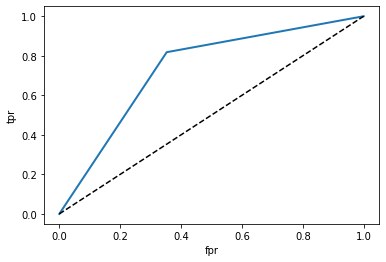

In [104]:
# Q. 코드를 작성해주세요

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

# Trial 1)
# auc:0.6724598930481284

# Trial 2)
# auc:0.7142379679144386

# Trial 3)
# auc:0.6887032085561497

# Trial 4)
# auc:0.732620320855615